In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Mar  5 09:39:51 2019

@author: chriswintersinger
"""

import pickle
import pandas as pd
import numpy as np
from scipy.spatial import distance
import seaborn as sns
import matplotlib.pyplot as plt
import numpy.ma as ma
import time

std_size = 20

# Change default matplotlib parameters
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['lines.markersize'] = 9
plt.rcParams['axes.labelsize'] = std_size
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = std_size
plt.rcParams['ytick.labelsize'] = std_size

weight = 2.54
plt.rcParams['axes.linewidth'] = weight
plt.rcParams['xtick.major.width'] = weight
plt.rcParams['ytick.major.width'] = weight

cm = 1#(1/2.54)
plt.rcParams['figure.figsize'] = [5.1*cm*1.25,3.4*cm*1.25]

plt.rcParams['legend.fontsize'] = std_size
plt.rcParams['legend.title_fontsize'] = std_size
plt.rcParams['axes.titlesize'] = std_size
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titlesize'] = std_size
plt.rcParams['figure.titleweight'] = 'bold'

def strip_null_test_binding_site_num(row, slat_num_binding_sites):
    '''
    Strips zeros from rows of binding sites to define a slat from the base matrix.
    '''
    putative_component = row[row != 0]
    mult_comp = []
        
    if len(putative_component) == slat_num_binding_sites: 
        return list(putative_component)
    
    if ((len(putative_component)/slat_num_binding_sites).is_integer() == True) and (len(putative_component)/slat_num_binding_sites)>1: 
        for val in range(0,len(putative_component),slat_num_binding_sites):
            mult_comp.append(list(putative_component[val:val+slat_num_binding_sites]))
        return tuple(mult_comp)
        
    if ((len(putative_component)/slat_num_binding_sites).is_integer() == False) and (len(putative_component)/slat_num_binding_sites)>1:
        print((len(putative_component)/slat_num_binding_sites), 'off series num sites')
        
    else: return False


def matrix_to_dict(matrix1, matrix2, series_key, test_binding_sites, x_start, y_start):
    '''
    Converts the matrix of binding sites into a dictionary that is keyed by the respective x- and y- slats.
    '''
    converted_dicts_xy = [{},{}]
    x_counter = x_start
    y_counter = y_start 
    
    for x_row in matrix1:
        test = strip_null_test_binding_site_num(x_row,test_binding_sites)
        if test == False: continue
        if type(test) == tuple:
            for val in range(len(test)):
                converted_dicts_xy[0][series_key + 'x' + str(int(x_counter))] = test[val]
                x_counter += 1
                
        if type(test) == list:
            converted_dicts_xy[0][series_key + 'x' + str(int(x_counter))] = test
            x_counter += 1  

    for y_column in matrix2:
        test = strip_null_test_binding_site_num(y_column,test_binding_sites)
        if test == False: continue
        if type(test) == tuple:
            for val in range(len(test)):
                converted_dicts_xy[1][series_key + 'y' + str(int(y_counter))] = test[val]
                y_counter+=1
                
        if type(test) == list:
            converted_dicts_xy[1][series_key + 'y' + str(int(y_counter))] = test
            y_counter += 1

    return converted_dicts_xy

def pairwise_compare_lists(list1, list2,slat_len=32):
    '''
    Input lists are two slats being compared to one another. 
    The haming distance is computed between list2 and list1 across all possible forward and reverse registers.
    distance.hamming requries that the lists in comparison be the same length such that filler zeros are added to list1 when testing a different register.
    '''    
    haming_return = [0]
    
    rev_list1 = list1[::-1]
    for start in range(len(list1)):
        haming_return.append(slat_len - distance.hamming(list1[start:]+len(list1[:start])*[0], list2)*slat_len)
        haming_return.append(slat_len - distance.hamming(len(list1[start:])*[0]+list1[:start], list2)*slat_len)
        
        haming_return.append(slat_len - distance.hamming(rev_list1[start:]+len(rev_list1[:start])*[0], list2)*slat_len)
        haming_return.append(slat_len - distance.hamming(len(rev_list1[start:])*[0]+rev_list1[:start], list2)*slat_len)
        
    return max(haming_return),haming_return


def pairwise_compare_lists_alt(list1, list2,slat_len=32):
    '''
    Input lists are two slats being compared to one another. 
    The haming distance is computed between list2 and list1 across all possible forward and reverse registers.
    distance.hamming requries that the lists in comparison be the same length such that filler zeros are added to list1 when testing a different register.
    '''    
    haming_return = [0]
    haming_ck = []
    
    rev_list1 = list1[::-1]
    for start in range(len(list1)):
        
        val = slat_len - distance.hamming(list1[start:]+len(list1[:start])*[0], list2)*slat_len
        haming_return.append(val)
        haming_ck.append([val,list1[start:]+len(list1[:start])*[0],list2])
        
        val = slat_len - distance.hamming(len(list1[start:])*[0]+list1[:start], list2)*slat_len
        haming_return.append(val)
        haming_ck.append([val,len(list1[start:])*[0]+list1[:start],list2])
        
        val = slat_len - distance.hamming(rev_list1[start:]+len(rev_list1[:start])*[0], list2)*slat_len
        haming_return.append(val)
        haming_ck.append([val,rev_list1[start:]+len(rev_list1[:start])*[0], list2])
        
        val = slat_len - distance.hamming(len(rev_list1[start:])*[0]+rev_list1[:start], list2)*slat_len
        haming_return.append(val)
        haming_ck.append([val,len(rev_list1[start:])*[0]+rev_list1[:start], list2])
        
    return max(haming_return),haming_return,haming_ck


def pairwise_compare_dict_alt(dict1,dict2):
    '''
    '''
    global all_ret_ck
    all_ret_ck = []
    
    for key1 in dict1: 
        for key2 in dict2: 
            if pairwise_compare_lists(dict1[key1], dict2[key2])[0] == 0: 
                continue
            else:
                all_ret_ck.append(pairwise_compare_lists_alt(dict1[key1], dict2[key2])[2])

def pairwise_compare_dict(dict1,dict2):
    '''
    '''
    global all_ret_sing
    all_ret_sing = []
    
    for key1 in dict1: 
        for key2 in dict2:
            test = pairwise_compare_lists(dict1[key1], dict2[key2])
            if test[0] == 0: 
                continue
            else:
                all_ret_sing.append(test[1])


def swap_section(matrix_base, matrix_swap, coordinate_swap, coordinate_origin, coordinate_destination):
    '''
    '''
    #Temporary matrix to store data from base matrix that is to be inserted into the swap matrix
    swap_region_matrix = np.empty([coordinate_swap[0], coordinate_swap[1]])
    
    #Gather matrix info to be swapped into the temporary swap region matrix
    for row in range(coordinate_origin[0], (coordinate_origin[0] + coordinate_swap[0])):
        for column in range(coordinate_origin[1], (coordinate_origin[1] + coordinate_swap[1])):
            swap_region_matrix[row - coordinate_origin[0]][column - coordinate_origin[1]] = matrix_base[row][column]
    
    #Insert swap region matrix into the destination matrix
    for row in range(coordinate_destination[0], (coordinate_destination[0] + coordinate_swap[0])):
        for column in range(coordinate_destination[1], (coordinate_destination[1] + coordinate_swap[1])):
            matrix_swap[row][column] = swap_region_matrix[row - coordinate_destination[0]][column - coordinate_destination[1]]     

    return matrix_swap

def output_excel_sheet(component_location_dict, excel_workbook, excel_sheet_destination):
    '''
    '''
    #df = pd.DataFrame(data=component_location_dict)
    df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in component_location_dict.items() ]))

    #writer = ExcelWriter(excel_workbook_destination)
    #df.to_excel(writer,excel_sheet_destination,index=False)
    
    writer = excel_workbook
    df.to_excel(writer, sheet_name=excel_sheet_destination)

# RANDOM NUMBER ASSIGNMENT TO NULL MATRICES

In [15]:
##PROPER STAGGER TO BE ADDED TO FINAL... NOT SCRIPTED
final_pipette_instruction_workbook = pd.ExcelWriter('output_test.xlsx', engine='xlsxwriter')
template_x = np.array(pd.ExcelFile('input_example.xlsx').parse("square_x").values)
template_y = np.array(pd.ExcelFile('input_example.xlsx').parse("square_y").values)

# List of strengths of kinetic traps to test in the matrices. Assuming you're using the 32x depth library:
## For structures with hundreds to a thousand slats, you probably won't be able to beat 8. But I found that 8 here grew fine.
## For structures with ~64 slats like the square, you should be able to get a strength 6. 
trap_thresh = [7,6,5,4]

# Upper bound of the 32x sequence library to use. Max value with current library is 32.
lib = 32


# I run
for trap in trap_thresh:
    complete = False
    iteration = 0
    
    while complete == False:
        now_1 = time.time()
        
        ##Popluate x ghost with random
        #Indexing for randint on high bounds is < uppper value. Hence add one.
        random = np.random.randint(1,high=(lib+1), size=template_x.shape) 
        m = np.ma.masked_where(template_x==0, template_x)                  
        test = np.ma.masked_where(np.ma.getmask(m), random) 
        ma.set_fill_value(test, 0)
        test = test.filled()
        
        ##Popluate x ghost with -2 to -1
        m = np.ma.masked_where(template_x==-2, template_x)
        test = np.ma.masked_where(np.ma.getmask(m), test)
        ma.set_fill_value(test, -1)
        test = test.filled()
        
        ##Popluate y ghost with random
        m = np.ma.masked_where(template_y==0, template_y)
        test_2 = np.ma.masked_where(np.ma.getmask(m), test)
        ma.set_fill_value(test_2, 0)
        test_2 = test_2.filled()
        
        #Convert the staggered matrix into dictionary of x- and y-slats 
        seq_matrix = matrix_to_dict(test,test_2.transpose(),'',32,0,0)
        
        #xy or kinetic traps
        pairwise_compare_dict(seq_matrix[0],seq_matrix[1])
        set_xy = all_ret_sing
        
        #xx or misbinding in x-direction
        #pairwise_compare_dict(seq_matrix[0],seq_matrix[0])
        #set_xx = all_ret_sing
        
        #yy or misbinding in y-direction
        #pairwise_compare_dict(seq_matrix[1],seq_matrix[1])
        #set_yy = all_ret_sing

        collapse_xy = [val for row in set_xy for val in row[1:]]
        #collapse_xx = [val for row in set_xx for val in row[1:] if val != 32]
        #collapse_yy = [val for row in set_yy for val in row[1:] if val != 32]

        now_2 = time.time()
        print("It has been {0} seconds testing the below design".format(now_2 - now_1))
        print('Max trap measured is', max(collapse_xy), ', Multiplicity of desired trap', str(trap), 'is',
              collapse_xy.count(trap), ', Depth of library is', lib, ', Current trap being tested', trap, '\n')
        iteration+=1
        if (max(collapse_xy) == trap):complete=True #and (max(collapse_xx) <= 8) and (max(collapse_yy) <= 8): complete = True
    
    output_excel_sheet(pd.DataFrame(test), final_pipette_instruction_workbook, 'x-k'+str(int(max(collapse_xy)))+'-'+
                       str(collapse_xy.count(max(collapse_xy)))+'_slats'+str(len(seq_matrix[0])))
    output_excel_sheet(pd.DataFrame(test_2), final_pipette_instruction_workbook, 'y-k'+str(int(max(collapse_xy)))+'-'+
                       str(collapse_xy.count(max(collapse_xy)))+'_slats'+str(len(seq_matrix[1])))

final_pipette_instruction_workbook.save()

It has been 7.025500535964966 seconds testing the below design
Max trap measured is 7.0 , Multiplicity of desired trap 7 is 1 , Depth of library is 32 , Current trap being tested 7 

It has been 7.000792026519775 seconds testing the below design
Max trap measured is 7.0 , Multiplicity of desired trap 6 is 11 , Depth of library is 32 , Current trap being tested 6 

It has been 6.904213905334473 seconds testing the below design
Max trap measured is 6.0 , Multiplicity of desired trap 6 is 8 , Depth of library is 32 , Current trap being tested 6 

It has been 6.70004415512085 seconds testing the below design
Max trap measured is 6.0 , Multiplicity of desired trap 5 is 58 , Depth of library is 32 , Current trap being tested 5 

It has been 6.621643304824829 seconds testing the below design
Max trap measured is 8.0 , Multiplicity of desired trap 5 is 72 , Depth of library is 32 , Current trap being tested 5 

It has been 6.9244794845581055 seconds testing the below design
Max trap measured i

KeyboardInterrupt: 

In [16]:
final_pipette_instruction_workbook.save()

# OTHER

In [17]:
#Code below is for plotting of the final output matrices from above. I typically manucally copy and paste the 
# matrix from the csv into my excel sheet for archival purposes in the experiment. Also a good sanity check of my output.
# Obviously, this isn't necessary and just my own workflow. 

x = np.array(pd.ExcelFile('output_test.xlsx').parse("x-k6-8_slats32").values)
y = np.array(pd.ExcelFile('output_test.xlsx').parse("y-k6-8_slats32").values)

seq_matrix = matrix_to_dict(x,y.transpose(),'',32,0,0)
pairwise_compare_dict(seq_matrix[0],seq_matrix[1])
set_xy = all_ret_sing

pairwise_compare_dict(seq_matrix[0],seq_matrix[0])
set_xx = all_ret_sing

pairwise_compare_dict(seq_matrix[1],seq_matrix[1])
set_yy = all_ret_sing

collapse_xy = [val for row in set_xy for val in row[1:]]
collapse_xx = [val for row in set_xx for val in row[1:] if val != 32]
collapse_yy = [val for row in set_yy for val in row[1:] if val != 32]

print('Max xx', max(collapse_xx),'Max yy', max(collapse_yy),'Max xy', max(collapse_xy), 'Count max xy', collapse_xy.count(max(collapse_xy)))

Max xx 8.0 Max yy 7.0 Max xy 6.0 Count max xy 8


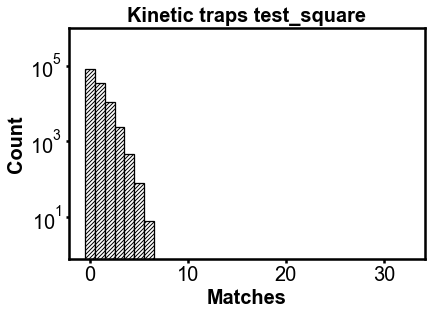

In [27]:
import matplotlib.pyplot as plt
collapse_xy = [val for row in set_xy for val in row[1:]]# if val !=0]
collapse_xx = [val for row in set_xx for val in row[1:]]# if val !=0]
collapse_yy = [val for row in set_yy for val in row[1:]]# if val !=0]

collapse_xy = np.array(collapse_xy)
collapse_xx = np.array(collapse_xx)
collapse_yy = np.array(collapse_yy)

weight = 2.54
val_cust = 'test_square'
y_max = .8,10**6

d = np.diff(np.unique(collapse_xy)).min()
left_of_first_bin = collapse_xy.min() - float(d)/2
right_of_last_bin = 32 + float(d)/2
plt.hist(collapse_xy, np.arange(left_of_first_bin, right_of_last_bin + d, d), color='white', edgecolor='k', hatch='//////', linewidth=weight/2)
#plt.xlim(-1,33)
plt.ylim(y_max)
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Matches')
plt.title('Kinetic traps '+val_cust)
plt.savefig(val_cust+'_perm_kintrap.svg')
plt.show()

In [20]:
collapse_xy

array([2., 0., 0., ..., 1., 0., 1.])